In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Cleaned_dataset.csv', index_col=0)

In [3]:
df.drop(columns=['Unit of Measure (Per Pack)', 'Vendor INCO Term', 'Product Group', 'Sub Classification', 'Brand', 'Dosage', 'Fulfill Via', 'First Line Designation'], inplace=True)

In [4]:
df.rename(columns={'Country':'Drop point'}, inplace=True)

In [5]:
df.columns = ['Drop_point','Shipment_Mode','Dosage_Form','Line_Item_Quantity','Line_Item_Value',
                          'Pack_Price','Unit_Price','Weight','Freight_Cost',
                          'Line_Item_Insurance','Delivery_Status','Pickup_Point']

In [6]:
df.to_csv('updated_dataset.csv', index=0)

In [7]:
df=pd.read_csv('updated_dataset.csv')

In [8]:
df.head()

,Drop_point,Shipment_Mode,Dosage_Form,Line_Item_Quantity,Line_Item_Value,Pack_Price,Unit_Price,Weight,Freight_Cost,Line_Item_Insurance,Delivery_Status,Pickup_Point
0,Côte d'Ivoire,Air,Test kit,19,551.0,29.00,0.97,13.0,780.34,NaN,On time,NaN
1,Vietnam,Air,Others,1000,6200.0,6.20,0.03,358.0,4521.50,NaN,On time,India
2,Côte d'Ivoire,Air,Test kit,500,40000.0,80.00,0.80,171.0,1653.78,NaN,On time,Others
3,Vietnam,Air,Tablet,31920,127360.8,3.99,0.07,1855.0,16007.06,NaN,On time,India
4,Vietnam,Air,Others,38000,121600.0,3.20,0.05,7590.0,45450.08,NaN,On time,India


### Filling the Missing values

In [9]:
def knn_impute(data, na_target):
    
    df1 = data.copy()
    
    numeric_df = df1.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[:, numeric_df.isna().sum() == 0].columns
    
    y_train_im = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train_im = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test_im = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train_im, y_train_im)
    
    y_pred_im = knn.predict(X_test_im)
    
    df1.loc[numeric_df[na_target].isna() == True, na_target] = y_pred_im

    return df1

In [10]:
for column in ['Weight',
               'Freight_Cost',
               'Line_Item_Insurance']:
    df = knn_impute(df, column)

In [11]:
df.select_dtypes(np.number).isnull().sum()

Line_Item_Quantity     0
Line_Item_Value        0
Pack_Price             0
Unit_Price             0
Weight                 0
Freight_Cost           0
Line_Item_Insurance    0
dtype: int64

In [12]:
df1 = df.copy()

#### Dividing Dependent and Independent Variables

In [13]:
X = df1.drop(columns=['Line_Item_Value'])
y = df1['Line_Item_Value']

In [14]:
#Segregating numerical and nominal and categorical variables
numerical_cols = X.select_dtypes(exclude='object').columns

In [15]:
X.select_dtypes('O').describe().T

,count,unique,top,freq
Drop_point,10324,17,South Africa,1406
Shipment_Mode,9964,4,Air,6113
Dosage_Form,10324,4,Tablet,3532
Delivery_Status,10324,3,On time,6324
Pickup_Point,9222,2,India,5725


In [16]:
Nominal_categorical_cols = ['Drop_point','Dosage_Form','Pickup_Point']

In [17]:
Ord_categorical_cols = ['Delivery_Status', 'Shipment_Mode']

In [18]:
delivery_status = ['Delivered Early', 'On time', 'Delayed']
shipment_mode = ['Air', 'Truck', 'Air Charter', 'Ocean']

In [19]:
### Feature Transformation

skew_df = pd.DataFrame(X.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(X[feature]))
skew_df['Skewed'] = skew_df['Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Skewed
0,Line_Item_Quantity,5.037583,True
1,Pack_Price,12.986545,True
2,Unit_Price,40.578952,True
3,Weight,47.346598,True
4,Freight_Cost,4.957242,True
5,Line_Item_Insurance,4.862114,True


In [20]:
for column in skew_df.query('Skewed == True')['Feature'].values:
    X[column] = np.log1p(X[column])

In [21]:
skew_df = pd.DataFrame(X.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(X[feature]))
skew_df['Skewed'] = skew_df['Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Skewed
0,Line_Item_Quantity,-0.483316,False
1,Pack_Price,0.490394,False
2,Unit_Price,4.129290,True
3,Weight,-0.442201,False
4,Freight_Cost,-0.277815,False
5,Line_Item_Insurance,-0.092782,False


### Target Transformation

In [22]:
y = np.log1p(y)

### Creating Pipeline 

In [23]:
## Numerical Pipeline

num_pipeline=Pipeline(
    steps=[
    #('imputer', SimpleImputer(strategy='median')),
    #('transformation', PowerTransformer(method='yeo-johnson')),
    ('scaling', StandardScaler())
    

    ]

)

# Nominal_Categorigal Pipeline
nom_cat_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoder', OneHotEncoder(drop='first'))
    
        
    ]
    
)

Ord_cat_pipeline = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=[delivery_status, shipment_mode]))
        
    ]
)



preprocessor=ColumnTransformer([
('num_pipeline',num_pipeline,numerical_cols),
('nom_cat_pipeline',nom_cat_pipeline,Nominal_categorical_cols),
('Ord_cat_pipeline', Ord_cat_pipeline, Ord_categorical_cols)
])

### Train test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((8259, 11), (2065, 11), (2065,), (8259,))

In [26]:
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [27]:
X_train.columns

Index(['num_pipeline__Line_Item_Quantity', 'num_pipeline__Pack_Price',
       'num_pipeline__Unit_Price', 'num_pipeline__Weight',
       'num_pipeline__Freight_Cost', 'num_pipeline__Line_Item_Insurance',
       'nom_cat_pipeline__Drop_point_Côte d'Ivoire',
       'nom_cat_pipeline__Drop_point_Ethiopia',
       'nom_cat_pipeline__Drop_point_Guyana',
       'nom_cat_pipeline__Drop_point_Haiti',
       'nom_cat_pipeline__Drop_point_Kenya',
       'nom_cat_pipeline__Drop_point_Mozambique',
       'nom_cat_pipeline__Drop_point_Nigeria',
       'nom_cat_pipeline__Drop_point_Others',
       'nom_cat_pipeline__Drop_point_Rwanda',
       'nom_cat_pipeline__Drop_point_South Africa',
       'nom_cat_pipeline__Drop_point_South Sudan',
       'nom_cat_pipeline__Drop_point_Tanzania',
       'nom_cat_pipeline__Drop_point_Uganda',
       'nom_cat_pipeline__Drop_point_Vietnam',
       'nom_cat_pipeline__Drop_point_Zambia',
       'nom_cat_pipeline__Drop_point_Zimbabwe',
       'nom_cat_pipeline__Dosage

In [28]:
X_train.columns = [
    'Line Item Quantity', 
    'Pack Price',
    'Unit Price', 
    'Weight (Kilograms)',
    'Freight Cost (USD)',
    'Line Item Insurance (USD)',
    "Drop point_Côte d'Ivoire",
    'Drop point_Ethiopia',
    'Drop point_Guyana',
    'Drop point_Haiti',
    'Drop point_Kenya',
    'Drop point_Mozambique',
    'Drop point_Nigeria',
    'Drop point_Others',
    'Drop point_Rwanda',
    'Drop point_South Africa',
    'Drop point_South Sudan',
    'Drop point_Tanzania',
    'Drop point_Uganda',
    'Drop point_Vietnam',
    'Drop point_Zambia',
    'Drop point_Zimbabwe',
    'Dosage Form_Tablet',
    'Dosage Form_Tablet - FDC',
    'Dosage Form_Test kit',
    'Pickup Point_Others',
    'Delivery Status',
    'Shipment Mode'
]

In [29]:
X_test.columns = [
    'Line Item Quantity', 
    'Pack Price',
    'Unit Price', 
    'Weight (Kilograms)',
    'Freight Cost (USD)',
    'Line Item Insurance (USD)',
    "Drop point_Côte d'Ivoire",
    'Drop point_Ethiopia',
    'Drop point_Guyana',
    'Drop point_Haiti',
    'Drop point_Kenya',
    'Drop point_Mozambique',
    'Drop point_Nigeria',
    'Drop point_Others',
    'Drop point_Rwanda',
    'Drop point_South Africa',
    'Drop point_South Sudan',
    'Drop point_Tanzania',
    'Drop point_Uganda',
    'Drop point_Vietnam',
    'Drop point_Zambia',
    'Drop point_Zimbabwe',
    'Dosage Form_Tablet',
    'Dosage Form_Tablet - FDC',
    'Dosage Form_Test kit',
    'Pickup Point_Others',
    'Delivery Status',
    'Shipment Mode'
]

In [30]:
X_train.head()

,Line Item Quantity,Pack Price,Unit Price,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Drop point_Côte d'Ivoire,Drop point_Ethiopia,Drop point_Guyana,Drop point_Haiti,...,Drop point_Uganda,Drop point_Vietnam,Drop point_Zambia,Drop point_Zimbabwe,Dosage Form_Tablet,Dosage Form_Tablet - FDC,Dosage Form_Test kit,Pickup Point_Others,Delivery Status,Shipment Mode
0,-2.020566,0.612595,0.635282,-2.292517,-2.149140,-1.663837,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.375539,-0.808114,-0.438575,-0.511988,-0.699690,-0.162580,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.742709,-0.114020,-0.046720,0.683158,0.601650,0.653629,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.053870,-0.426304,-0.483600,0.761705,1.117598,0.854698,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-2.054114,1.050547,-0.460987,-0.835447,-0.830689,-1.556931,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [31]:
X_test.head()

,Line Item Quantity,Pack Price,Unit Price,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Drop point_Côte d'Ivoire,Drop point_Ethiopia,Drop point_Guyana,Drop point_Haiti,...,Drop point_Uganda,Drop point_Vietnam,Drop point_Zambia,Drop point_Zimbabwe,Dosage Form_Tablet,Dosage Form_Tablet - FDC,Dosage Form_Test kit,Pickup Point_Others,Delivery Status,Shipment Mode
0,1.170952,-0.523213,-0.308130,0.998165,0.550584,1.178954,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.555775,0.390219,0.390595,-1.500111,-1.570696,-0.481460,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-1.722463,1.361760,0.776968,-0.981778,-1.462817,-1.381937,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,-0.257450,-0.556929,-0.329408,0.667922,0.966235,-0.687587,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
4,0.238051,-2.304459,-0.746729,0.246763,1.061833,-1.736763,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [32]:
from sklearn.linear_model import Lasso, Ridge

In [33]:
regressor = XGBRegressor(booster='gbtree', max_depth=6, learning_rate=0.1, n_estimators=100)

In [34]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
y_pred_test = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)
print('Model Performance on Train set:', r2_score(y_train, y_pred_train))
print('Model Performance on Test set:', r2_score(y_test, y_pred_test))

Model Performance on Train set: 0.998561062819479
Model Performance on Test set: 0.997458824971207


In [36]:
np.sqrt(mean_squared_error(y_test, y_pred_test))

0.13258482409109587

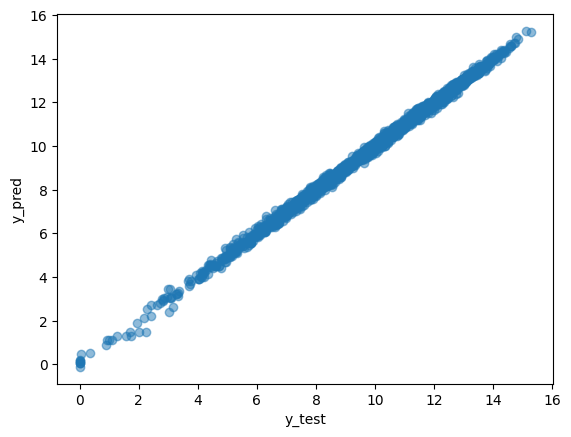

In [37]:
### plot performance graph

y_pred = regressor.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [38]:
residuals = y_test - y_pred

<Axes: xlabel='Line_Item_Value', ylabel='Density'>

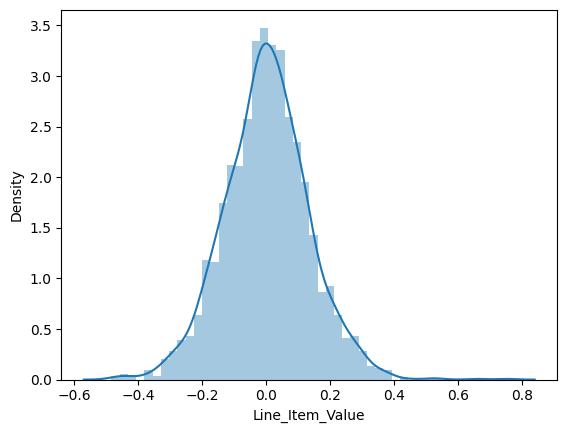

In [39]:
sns.distplot(residuals, kde=True)

In [40]:
import pickle
pickle.dump(preprocessor, open('preprocessor.pkl', 'wb'))

In [41]:
with open('preprocessor.pkl', 'rb') as f:
    o = pickle.load(f)

In [44]:
pickle.dump(regressor, open('regressor.pkl', 'wb'))